In [1]:
# 75.06 - 1C202 - TP2 
# Competencia de Machine learning
#
# https://www.kaggle.com/c/nlp-getting-started/overview
#
# Fuentes:
# https://realpython.com/python-keras-text-classification/
# https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28
# https://www.kaggle.com/friskycodeur/nlp-with-disaster-tweets-bert-explained

# Importacion de librerias necesarias
import re, string, random, datetime
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Split y K-Fold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Importacion de Keras
# https://keras.io
from keras.models import Model, Sequential, save_model, load_model
from keras.layers import Embedding, Conv1D, Dropout, Input, GlobalMaxPooling1D, Dense, concatenate, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from bert import bert_tokenization


#Configuracion general
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

import tokenization

In [2]:
# Path de entrada
# Probamos con esta salida del pre-procesador
# Pasaje a minúsculas:   True (limpieza sin pasaje a miniustculas dio .80)
# Limpieza básica:       True (limpieza y minisculas dio .82)
# Agregado de keywords:  True (limpieza, minusculas y keywords .83 <-- 5 epochs: )
# Agregado de location:  False (limpieza, minusculas, keywords y location dio 0.8228623965675759  )
# Remoción de stopwords: False (limpieza, minusculas, keywords, sin stopwords dio .81)
# Stemming:              False
# Lematización:          False (limpieza, minusculas, keywords, con lemming .77)
# Aumento del set:       False
# Chequeo final:         True

# Generado train: 'data/processed/train.2020.08.05T13.30.30.679045.csv' - (7613) registros.
# Generado test:  'data/processed/test.2020.08.05T13.30.30.679045.csv' - (3263) registros.
    
train_path = 'data/processed/train.2020.08.05T13.30.30.679045.csv' #Cambiar por el archivo pre-procesado a usar!
test_path = 'data/processed/test.2020.08.05T13.30.30.679045.csv'   #Cambiar por el archivo pre-procesado a usar!

# Carga de los archivos del set de datos
# Set de train: carga
df_twitter_train = pd.read_csv(train_path, sep=',')
# Set de test: carga
df_twitter_test = pd.read_csv(test_path, sep=',')

# Print de los shapes
print('Shape train: ' + str(df_twitter_train.shape))
print('Shape test: ' + str(df_twitter_test.shape))

Shape train: (7613, 4)
Shape test: (3263, 3)


In [3]:
df_twitter_train.head()

,id,keyword,text,target
0,1,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,forest fire near la ronge sask canada,1
2,5,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,just got sent this photo from ruby alaska as s...,1


In [4]:
df_twitter_test.head()

,id,keyword,text
0,0,NaN,just happened a terrible car crash
1,2,NaN,heard about earthquake is different cities sta...
2,3,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,apocalypse lighting spokane wildfires
4,11,NaN,typhoon soudelor kills in china and taiwan


In [5]:
# Funciones AUXILIARES
# Grafica para un modelo los resultados del entrenamiento
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validación')
    plt.title('Accuracy: validación y entrenamiento')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validación')
    plt.title('Loss: validación y entrenamiento')
    plt.legend()
    plt.show()

In [6]:
# Defino funcion bert_encode
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [7]:
# Construimos el modelo
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
# Cargamos BERT desde tensorflow
# Bajar el tar.gz y descomprimirlo en el directorio bert.modules
# https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2
module_url = 'bert.modules/bert_en_uncased_L-24_H-1024_A-16_2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
# Nos quedamos con X e y para entrenar
tweets = df_twitter_train['text'].values
y = df_twitter_train['target'].values

# Separamos X para el set de test
tweets_predict = df_twitter_test['text'].values

train_encode_bert = bert_encode(tweets, tokenizer, max_len=160)
test_encode_bert = bert_encode(tweets_predict, tokenizer, max_len=160)
values_to_predict = df_twitter_train['target'].values

In [10]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [11]:
# Entrenamos el modelo
checkpoint = ModelCheckpoint('models/TP2_BERT_model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_encode_bert,
    values_to_predict,
    validation_split=0.2,
    epochs=5,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/5
381/381 [==============================] - 16821s 44s/step - loss: 0.4398 - accuracy: 0.8148 - val_loss: 0.4012 - val_accuracy: 0.8339
Epoch 2/5
381/381 [==============================] - 17906s 47s/step - loss: 0.3385 - accuracy: 0.8611 - val_loss: 0.3751 - val_accuracy: 0.8352
Epoch 3/5
381/381 [==============================] - 16390s 43s/step - loss: 0.2563 - accuracy: 0.9020 - val_loss: 0.4207 - val_accuracy: 0.8352
Epoch 4/5
381/381 [==============================] - 16214s 43s/step - loss: 0.1842 - accuracy: 0.9284 - val_loss: 0.5479 - val_accuracy: 0.8070
Epoch 5/5
381/381 [==============================] - 16200s 43s/step - loss: 0.1243 - accuracy: 0.9555 - val_loss: 0.5719 - val_accuracy: 0.8175


In [12]:
# Mostramos el historial del entrenamiento
metrics=pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.439822,0.814778,0.401202,0.833880
1,0.338457,0.861084,0.375063,0.835194
2,0.256316,0.901970,0.420687,0.835194
3,0.184240,0.928407,0.547908,0.806960
4,0.124337,0.955501,0.571897,0.817466


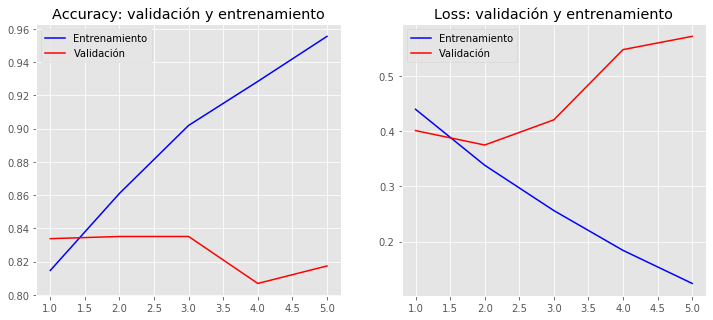

In [13]:
# Mostramos el historial del entrenamiento en forma grafica
plot_history(model.history)

In [14]:
# Hacemos la prediccion
model.load_weights('models/TP2_BERT_model.h5')
y_predict = model.predict(test_encode_bert)

In [15]:
# Generamos el submit
kaggle_submission = pd.DataFrame(df_twitter_test,columns = ['id'])
kaggle_submission['target'] = (y_predict > 0.5).astype('int32')

submission_path = 'data/submits/submission.' + datetime.datetime.now().isoformat() + '.csv'
submission_path = submission_path.replace('-','.').replace(':','.')

kaggle_submission.to_csv(submission_path, index=False)

# Imprimimos un resumen de la operacion
print('Operación finalizada!\n')
print('Generado submit: \'' + submission_path + '\' - (' + str(len(kaggle_submission['target'].index)) + ') registros.')

Operación finalizada!

Generado submit: 'data/submits/submission.2020.08.09T12.44.21.824280.csv' - (3263) registros.
